## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [89]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from sklearn.model_selection import train_test_split
from random import sample
import random
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Dropout
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import tqdm
import keras
from sklearn.metrics import confusion_matrix

## Do some early processing of your metadata for easier model training:

In [4]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
57710,00014299_007.png,No Finding,7,14299,44,F,PA,2992,2991,0.143,0.143,NaN,/data/images_007/images/00014299_007.png
89944,00022336_001.png,No Finding,1,22336,32,F,PA,2544,3056,0.139,0.139,NaN,/data/images_010/images/00022336_001.png
59863,00014784_003.png,No Finding,3,14784,28,M,PA,2992,2991,0.143,0.143,NaN,/data/images_007/images/00014784_003.png


In [5]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_diseases = np.unique(list(chain(*all_xray_df['Finding Labels'].apply(lambda x : x.split('|')))))

for disease in all_diseases:
    all_xray_df[disease] = all_xray_df['Finding Labels'].apply(lambda x : int(disease in x))

In [6]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].astype(str)
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
106768,00028808_002.png,No Finding,2,28808,68,F,AP,3056,2544,0.139,...,0,0,0,0,1,0,0,0,0,0
45960,00011768_000.png,No Finding,0,11768,56,F,AP,2500,2048,0.168,...,0,0,0,0,1,0,0,0,0,0
56284,00014022_015.png,Effusion|Pneumonia,15,14022,65,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,1,0,1


## Create your training and testing data:

In [7]:
def balance_classes(df, np_ratio, target='pneumonia_class', seed=None):
    # Subsample df such that the ratio of negative cases to positive cases is np_ratio
    
    if seed != None:
        random.seed(seed)
    
    n_idx = df[df[target] == '0'].index.to_list() # idx of -ve cases
    p_idx = df[df[target] == '1'].index.to_list() # idx of +ve cases
    
    # Find out which class needs to be subsampled in order to give the desired balance
    if len(n_idx) > (np_ratio * len(p_idx)):
        idx_keep, idx_sample = p_idx, n_idx
        sample_ratio = np_ratio
    else:
        idx_keep, idx_sample = n_idx, p_idx
        sample_ratio = 1. / np_ratio

    # Subsample one of the classes s.t. the # of -ve cases is np_ratio times the # of +ve cases
    idx_sample = sample(idx_sample, int(sample_ratio * len(idx_keep)))
    
    return df.loc[idx_sample + idx_keep]

In [8]:
def create_splits(df, val_size=0.2, train_ratio=1, val_ratio=3, target='pneumonia_class', identifier='Patient ID', seed=None):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    if seed != None:
        random.seed(seed)
    
    # Group by ID and take most frequent target diagnosis as placeholder value
    aggregated = df.groupby([identifier])[target].agg(lambda x : x.value_counts().index[0])
    aggregated = aggregated.reset_index().rename(columns={target : 'target mode'})
    
    # Carry out stratified split on patient IDs
    train_ids, val_ids = train_test_split(aggregated, stratify=aggregated['target mode'], test_size=val_size, random_state=seed)
    
    # Get all images for patients in each set
    train_data = pd.merge(df, train_ids, on='Patient ID').drop('target mode', axis=1)
    val_data = pd.merge(df, val_ids, on='Patient ID').drop('target mode', axis=1)
    
    # Balance classes in each set according to train_ratio and test_ratio
    train_data = balance_classes(train_data, train_ratio, target=target, seed=seed)
    val_data = balance_classes(val_data, val_ratio, target=target, seed=seed)
    
    return train_data, val_data

In [17]:
train_data, val_data = create_splits(all_xray_df, seed=1234)
len(train_data), len(val_data)

(2310, 1104)

In [18]:
# Check split has worked as intended

print('Below should give 0 (overlap of patients between train and val set)')
print(len(set(train_data['Patient ID']).intersection(set(val_data['Patient ID']))))

print('\nBelow should give around val_size')
print(sum(val_data['pneumonia_class'] == '1') / (sum(val_data['pneumonia_class'] == '1') + sum(train_data['pneumonia_class'] == '1')))

print('\nBelow should give train_ratio')
print(sum(train_data['pneumonia_class'] == '0') / sum(train_data['pneumonia_class'] == '1'))

print('\nBelow should give val_ratio')
print(sum(val_data['pneumonia_class'] == '0') / sum(val_data['pneumonia_class'] == '1'))

print('\nBelow should give two approx. similar values (Infiltration rate among -ve cases for each set)')
print(sum((val_data['pneumonia_class'] == '0') & (val_data['Infiltration'] == 1)) / sum(val_data['pneumonia_class'] == '0'))
print(sum((train_data['pneumonia_class'] == '0') & (train_data['Infiltration'] == 1)) / sum(train_data['pneumonia_class'] == '0'))

print('\nBelow should give two approx. similar values (Edema rate among -ve cases for each set)')
print(sum((val_data['pneumonia_class'] == '0') & (val_data['Edema'] == 1)) / sum(val_data['pneumonia_class'] == '0'))
print(sum((train_data['pneumonia_class'] == '0') & (train_data['Edema'] == 1)) / sum(train_data['pneumonia_class'] == '0'))

print('\nBelow should give two approx. similar values (Infiltration rate among +ve cases for each set)')
print(sum((val_data['pneumonia_class'] == '1') & (val_data['Infiltration'] == 1)) / sum(val_data['pneumonia_class'] == '1'))
print(sum((train_data['pneumonia_class'] == '1') & (train_data['Infiltration'] == 1)) / sum(train_data['pneumonia_class'] == '1'))

print('\nBelow should give two approx. similar values (Edema rate among +ve cases for each set)')
print(sum((val_data['pneumonia_class'] == '1') & (val_data['Edema'] == 1)) / sum(val_data['pneumonia_class'] == '1'))
print(sum((train_data['pneumonia_class'] == '1') & (train_data['Edema'] == 1)) / sum(train_data['pneumonia_class'] == '1'))

Below should give 0 (overlap of patients between train and val set)
0

Below should give around val_size
0.1928721174004193

Below should give train_ratio
1.0

Below should give val_ratio
3.0

Below should give two approx. similar values (Infiltration rate among -ve cases for each set)
0.17391304347826086
0.17575757575757575

Below should give two approx. similar values (Edema rate among -ve cases for each set)
0.016908212560386472
0.019913419913419914

Below should give two approx. similar values (Infiltration rate among +ve cases for each set)
0.44565217391304346
0.4173160173160173

Below should give two approx. similar values (Edema rate among +ve cases for each set)
0.2246376811594203
0.24069264069264068


### Explore training set

Positive cases: 1155
Negative cases: 1155
Ratio : 1.0



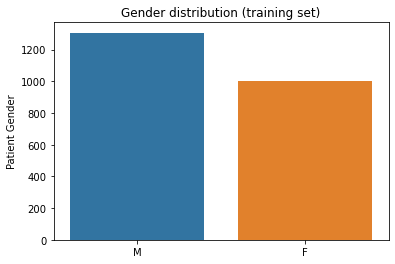

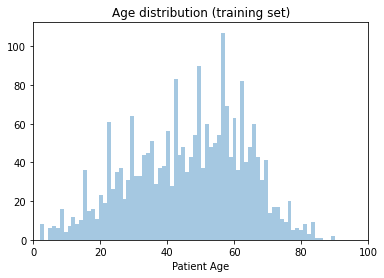

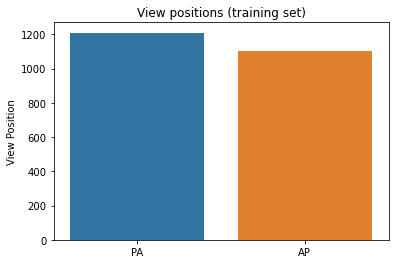

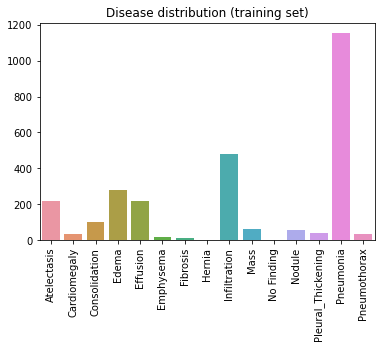

In [108]:
df_exp = train_data
dfstr = ' (training set)'
pos, neg = sum(df_exp['Pneumonia'] == 1), sum(df_exp['Pneumonia'] == 0)
print('Positive cases: {}'.format(pos))
print('Negative cases: {}'.format(neg))
print('Ratio : {}\n'.format(neg / pos))

# Gender dist
gend = df_exp['Patient Gender'].value_counts()
g = sns.barplot(x=gend.index, y=gend)
plt.title('Gender distribution' + dfstr)
plt.show()

# Age dist
g = sns.distplot(df_exp['Patient Age'], bins=75, kde=False)
g.axes.set_xlim(0, 100)
plt.title('Age distribution' + dfstr)
plt.show()

# Views
view = df_exp['View Position'].value_counts()
g = sns.barplot(x=view.index, y=view)
plt.title('View positions' + dfstr)
plt.show()

# Co occurrence
pneumonia_vector = df_exp['Pneumonia']
disease_matrix = df_exp[all_diseases].to_numpy()
cooccurrence = np.dot(pneumonia_vector, df_exp[all_diseases])

g = sns.barplot(x=all_diseases, y=cooccurrence)
g.set_xticklabels(all_diseases, rotation=90)
plt.title('Disease distribution' + dfstr)
plt.show()

### Explore validation set

Positive cases: 276
Negative cases: 828
Ratio : 3.0



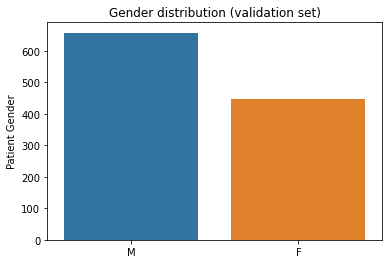

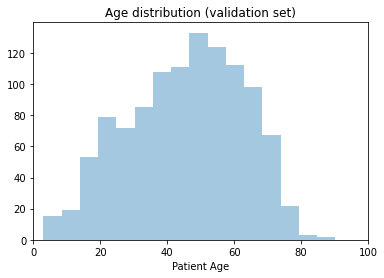

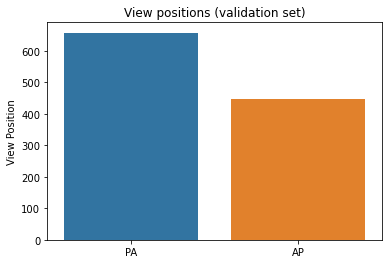

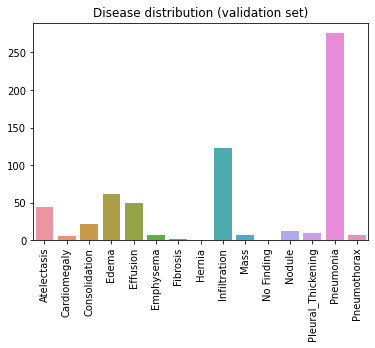

In [109]:
df_exp = val_data
dfstr = ' (validation set)'
pos, neg = sum(df_exp['Pneumonia'] == 1), sum(df_exp['Pneumonia'] == 0)
print('Positive cases: {}'.format(pos))
print('Negative cases: {}'.format(neg))
print('Ratio : {}\n'.format(neg / pos))

# Gender dist
gend = df_exp['Patient Gender'].value_counts()
g = sns.barplot(x=gend.index, y=gend)
plt.title('Gender distribution' + dfstr)
plt.show()

# Age dist
g = sns.distplot(df_exp['Patient Age'], bins=75, kde=False)
g.axes.set_xlim(0, 100)
plt.title('Age distribution' + dfstr)
plt.show()

# Views
view = df_exp['View Position'].value_counts()
g = sns.barplot(x=view.index, y=view)
plt.title('View positions' + dfstr)
plt.show()

# Co occurrence
pneumonia_vector = df_exp['Pneumonia']
disease_matrix = df_exp[all_diseases].to_numpy()
cooccurrence = np.dot(pneumonia_vector, df_exp[all_diseases])

g = sns.barplot(x=all_diseases, y=cooccurrence)
g.set_xticklabels(all_diseases, rotation=90)
plt.title('Disease distribution' + dfstr)
plt.show()

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [19]:
def my_image_augmentation(clear_defaults=False, **kwargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Default idg parameters
    idg_kwargs = dict(samplewise_center=True,
                    samplewise_std_normalization=True,
                    horizontal_flip=True, 
                    vertical_flip=False, 
                    height_shift_range=0.1, 
                    width_shift_range=0.1, 
                    rotation_range=10, 
                    shear_range = 0.1,
                    zoom_range=0.1)
    
    # Clear default idg parameters if clear_defaults=True
    if clear_defaults:
        idg_kwargs = dict()
    
    # Update parameters based on function input
    for kw, arg in kwargs.items():
        idg_kwargs[kw] = arg
    
    # Create idg
    my_idg = ImageDataGenerator(**idg_kwargs)
    
    return my_idg

def make_train_gen(train_data, my_train_idg, target_size=(224, 224)):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_data, 
                                                    directory=None, 
                                                    x_col='path',
                                                    y_col='pneumonia_class',
                                                    class_mode='binary',
                                                    target_size=target_size, 
                                                    batch_size=64)
    return train_gen

def make_val_gen(val_data, my_val_idg, target_size=(224, 224)):
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe=val_data, 
                                                directory=None, 
                                                x_col='path',
                                                y_col='pneumonia_class',
                                                class_mode='binary',
                                                target_size=target_size, 
                                                batch_size=32) 
    
    return val_gen

In [20]:
my_train_idg = my_image_augmentation()
my_val_idg = my_image_augmentation(clear_defaults=True,
                                  samplewise_center=True, samplewise_std_normalization=True)

In [21]:
train_gen = make_train_gen(train_data, my_train_idg)
val_gen = make_val_gen(val_data, my_val_idg)

Found 2310 validated image filenames belonging to 2 classes.
Found 1104 validated image filenames belonging to 2 classes.


In [22]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

In [23]:
# Generate test sets that have no image overlap with val set
testX, testY = val_gen.next()
for _ in range(len(val_gen) - 2):
    newX, newY = val_gen.next()
    testX = np.concatenate((testX, newX))
    testY = np.concatenate((testY, newY))
print(len(testX), len(testY))

1072 1072


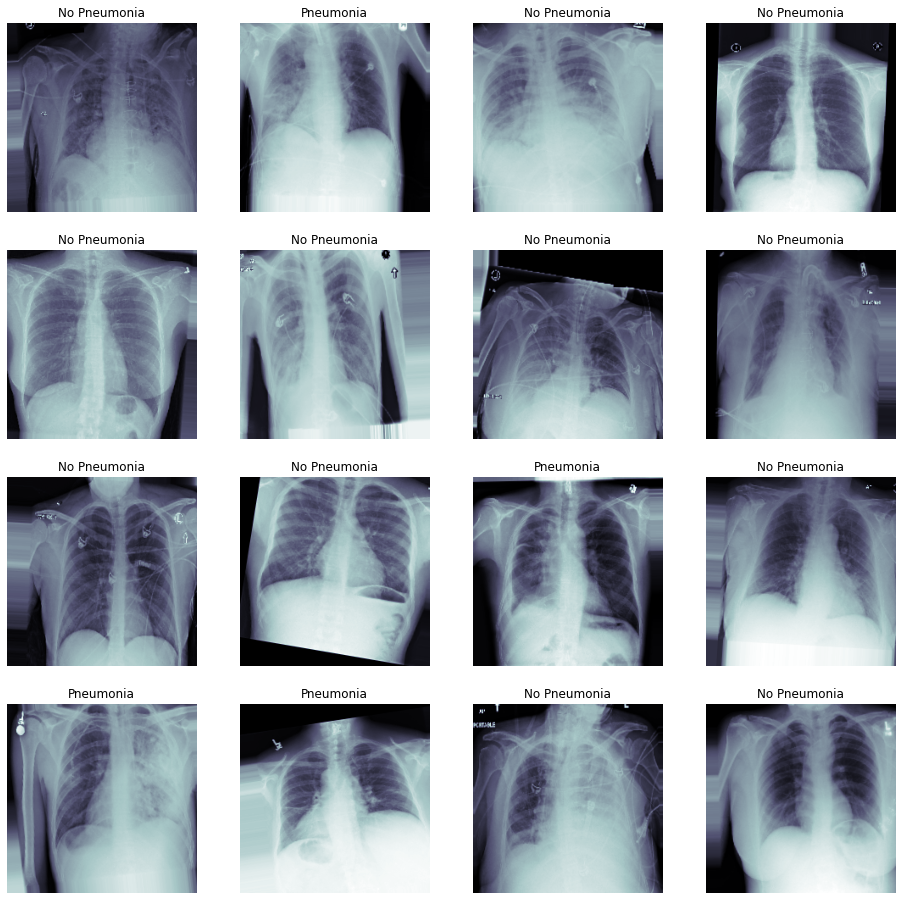

In [24]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = train_gen.next()
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [25]:
def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    return vgg_model

In [26]:
def build_my_model(pretrained, lr=1e-4):
    
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Freeze relevant layers
    for layer in pretrained.layers[:-2]:
        layer.trainable = False
    
    # Add flattened base to start building from pretrained model
    my_model = Sequential()
    my_model.add(pretrained)
    my_model.add(Flatten())
    
    p = 0.4 # droupout rate
    
    # Add dense and dropout layers
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(p))
    
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(p))
    
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dropout(p))
    
    # Ouput layer
    my_model.add(Dense(1, activation='sigmoid'))
    
    # Define optimizer, loss and metrics
    optimizer = optimizers.Adam(lr=lr)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    # Compile model
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [27]:
vgg16 = load_pretrained_model()
my_model = build_my_model(vgg16)

553467904/553467096 [==============================] - 7s 0us/step


In [28]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)              

In [29]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor='val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='min', 
                              save_weights_only = True)

early = EarlyStopping(monitor='val_loss', 
                       mode='min', 
                       patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [30]:
## train your model

history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 15, 
                          callbacks = callbacks_list)

Epoch 1/15
37/37 [==============================] - 71s 2s/step - loss: 0.7846 - binary_accuracy: 0.5303 - val_loss: 0.7429 - val_binary_accuracy: 0.2812

Epoch 00001: val_loss improved from inf to 0.74287, saving model to xray_class_my_model.best.hdf5
Epoch 2/15
37/37 [==============================] - 58s 2s/step - loss: 0.6952 - binary_accuracy: 0.5641 - val_loss: 0.5598 - val_binary_accuracy: 0.8125

Epoch 00002: val_loss improved from 0.74287 to 0.55978, saving model to xray_class_my_model.best.hdf5
Epoch 3/15
37/37 [==============================] - 61s 2s/step - loss: 0.6810 - binary_accuracy: 0.5848 - val_loss: 0.5229 - val_binary_accuracy: 0.8125

Epoch 00003: val_loss improved from 0.55978 to 0.52294, saving model to xray_class_my_model.best.hdf5
Epoch 4/15
37/37 [==============================] - 61s 2s/step - loss: 0.6537 - binary_accuracy: 0.6186 - val_loss: 0.5740 - val_binary_accuracy: 0.7188

Epoch 00004: val_loss did not improve from 0.52294
Epoch 5/15
37/37 [=========

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [31]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(testX, batch_size = 32, verbose = True)

1072/1072 [==============================] - 11s 10ms/step


In [32]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    curve = roc_curve(t_y, p_y)
    plt.plot(curve[0], curve[1])
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.title('ROC')
    plt.show()
    
    auc_score = auc(curve[1], curve[2])
    print('AUC = {}'.format(auc_score))
    return auc_score, curve

## what other performance statistics do you want to include here besides AUC? 
    
def plot_precision_recall_curve(t_y, p_y):
    curve = precision_recall_curve(t_y, p_y)
    plt.plot(curve[1], curve[0])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.title('Precision vs Recall')
    plt.show()
    
    return curve

def calc_f1(precision, recall):
    return 2 * (precision * recall) / (precision + recall)

def plot_f1_threshold_curve(prec_rec_curve):
    precision, recall, threshold = prec_rec_curve
    threshold = np.append(threshold, np.inf)
    f1s = []
    for prec, rec in zip(precision, recall):
        f1s += [calc_f1(prec, rec)]

    plt.plot(threshold, f1s)
    plt.ylabel('F1 score')
    plt.xlabel('Threshold')
    plt.title('F1 vs Threshold')
    plt.show()
    
    opt_thresh, max_f1 = threshold[np.argmax(f1s)], max(f1s)
    print('Optimum threshold = {}, Max F1 = {}'.format(opt_thresh, max_f1))
    return opt_thresh, max_f1
    
#Also consider plotting the history of your model training:

def plot_history(history, metrics=['loss', 'binary_accuracy']):
    fig, axs = plt.subplots(len(metrics), 1)
    plt.title('History')
    for i, met in enumerate(metrics):
        val = 'val_' + met
        axs[i].plot(history.epoch, history.history[met], label=met)
        axs[i].plot(history.epoch, history.history[val], label=val)
        axs[i].set_ylabel(met)
        axs[i].set_xlabel('epoch')
        axs[i].legend(loc='best')
    plt.tight_layout()
    plt.show()

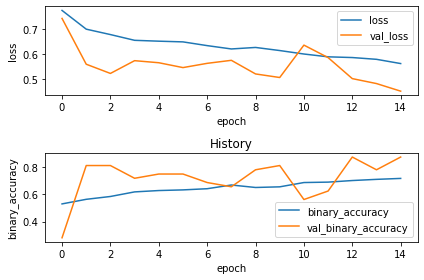

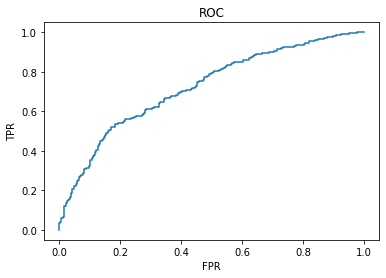

AUC = 0.5386275118216872


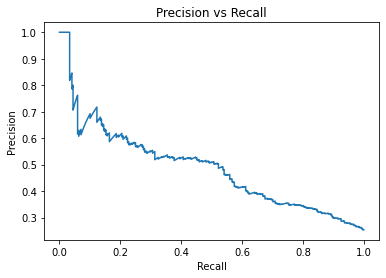

In [33]:
## plot figures
plot_history(history)

roc = plot_auc(testY, pred_Y)
prec_rec = plot_precision_recall_curve(testY, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

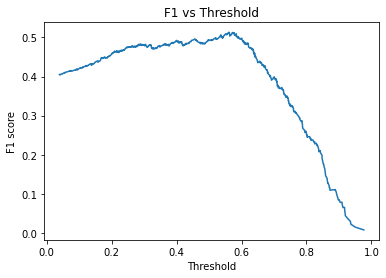

Optimum threshold = 0.5616551041603088, Max F1 = 0.5133689839572192


In [34]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

opt_thresh, max_f1 = plot_f1_threshold_curve(prec_rec)

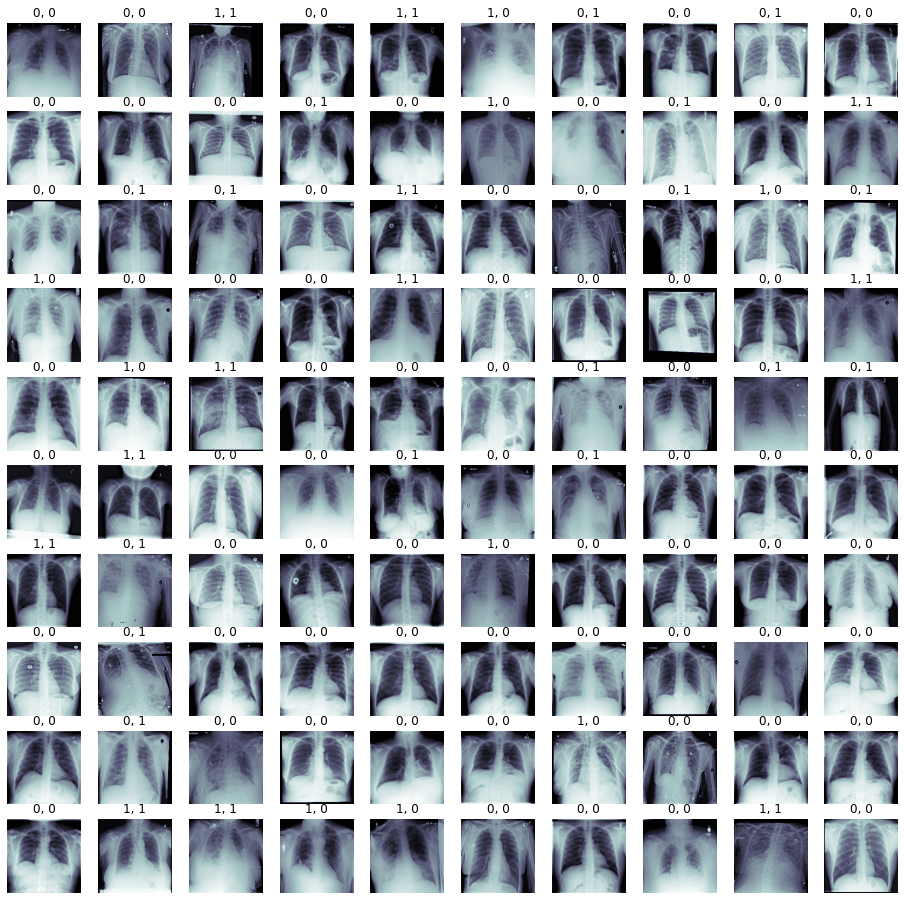

In [35]:
## Let's look at some examples of true vs. predicted with our best model: 

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(testX[0:100], testY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > opt_thresh:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > opt_thresh: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [36]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

# Testing model on different disease populations

In [37]:
def load_model(model_path, weight_path):
    # Load architecture from JSON
    json_file = open(model_path, 'r')
    model_json = json_file.read()
    json_file.close()
    model = keras.models.model_from_json(model_json)
    
    # Load weights from hdf5
    model.load_weights(weight_path)
    
    return model

In [38]:
model_path = 'my_model.json'
weight_path = 'xray_class_my_model.best.hdf5'
model_test = load_model(model_path, weight_path)

In [39]:
pred_Y = model_test.predict(testX, batch_size = 32, verbose = True)

1072/1072 [==============================] - 9s 9ms/step


In [40]:
opt_thresh = 0.5358442664146423
pred = pred_Y > opt_thresh

(tn, fp), (fn, tp) = confusion_matrix(testY, pred)
prec = tp / (tp + fp)
rec = tp / (tp + fn)
print("Precision = {}\nRecall = {}".format(prec, rec))

Precision = 0.4601226993865031
Recall = 0.5597014925373134


In [41]:
def disease_performance(disease):
    # Get model performance in presence of particular disease
    df = val_data[val_data[disease] == 1]
    idg = my_image_augmentation(clear_defaults=True,
                                samplewise_center=True, samplewise_std_normalization=True)
    gen = make_val_gen(df, my_val_idg)
    testX, testY = gen.next()
    for _ in range(len(gen) - 1):
        newX, newY = gen.next()
        testX = np.concatenate((testX, newX))
        testY = np.concatenate((testY, newY))
    print("Test set size for {}: {}".format(disease, len(testY)))
    
    pred_Y = model_test.predict(testX, batch_size = 32, verbose = True)
    pred = pred_Y > opt_thresh
    (tn, fp), (fn, tp) = confusion_matrix(testY, pred)
    acc = (tp + tn) / (tp + tn + fp + fn)
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = calc_f1(prec, rec)
    print("Accuracy = {}\nPrecision = {}\nRecall = {}\nF1 = {}".format(acc, prec, rec, f1))
    
    return dict(accuracy = acc, precision = prec, recall = rec, F1 = f1)

In [42]:
infil = disease_performance('Infiltration')

Found 267 validated image filenames belonging to 2 classes.
Test set size for Infiltration: 267
267/267 [==============================] - 4s 14ms/step
Accuracy = 0.700374531835206
Precision = 0.6482758620689655
Recall = 0.7642276422764228
F1 = 0.701492537313433


In [43]:
edema = disease_performance('Edema')

Found 76 validated image filenames belonging to 2 classes.
Test set size for Edema: 76
76/76 [==============================] - 2s 28ms/step
Accuracy = 0.7631578947368421
Precision = 0.8793103448275862
Recall = 0.8225806451612904
F1 = 0.8500000000000001


In [44]:
effusion = disease_performance('Effusion')

Found 148 validated image filenames belonging to 2 classes.
Test set size for Effusion: 148
148/148 [==============================] - 3s 23ms/step
Accuracy = 0.6283783783783784
Precision = 0.4594594594594595
Recall = 0.6938775510204082
F1 = 0.5528455284552845


In [45]:
atelectasis = disease_performance('Atelectasis')

Found 142 validated image filenames belonging to 2 classes.
Test set size for Atelectasis: 142
142/142 [==============================] - 3s 20ms/step
Accuracy = 0.6338028169014085
Precision = 0.39473684210526316
Recall = 0.3409090909090909
F1 = 0.36585365853658536


## Appendix - Featurewise Scaling
Bits of code I used for applying featurewise scaling which didn't produce very good models

Calculating mean...


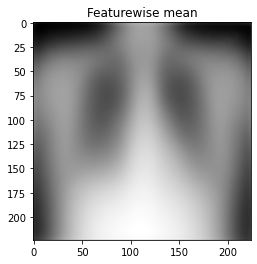

In [46]:
# Calculate featurewise mean of intensity values in dataset
print('Calculating mean...')
num_images = len(train_data['path'])
sum_means = 0
for i, path in enumerate(train_data['path']):
    img = np.asarray(Image.open(path).resize((224, 224)))
    if len(img.shape) == 3:
        img = img[:, :, 0]
    # Apply samplewise scaling first, as in ImageDataGenerator
    img = (img - img.mean()) / img.std()
    sum_means += img
    print('{} / {} training images processed\r'.format(i + 1, num_images), end="")
mean = sum_means / num_images
np.save('featurewise_mean', mean)
plt.imshow(mean, cmap='gray')
plt.title('Featurewise mean')
plt.show()

Calculating std...


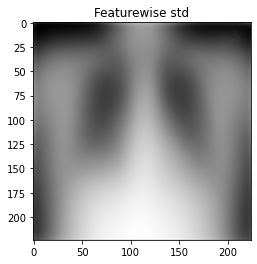

In [47]:
# Calculate featurewise std of intensity values in dataset
print('Calculating std...')
sum_stds = 0
for i, path in enumerate(train_data['path']):
    img = np.asarray(Image.open(path).resize((224, 224)))
    if len(img.shape) == 3:
        img = img[:, :, 0]
    sum_stds += (img - mean)**2
    print('{} / {} training images processed\r'.format(i + 1, num_images), end="")
std = np.sqrt(sum_stds / num_images)
np.save('featurewise_std', std)
plt.imshow(std, cmap='gray')
plt.title('Featurewise std')
plt.show()
std = std.reshape(224, 224, 1)

Most intensity and variation around where the xray-absorbing parts of the body are!

In [48]:
mean, std = mean.reshape(224, 224, 1), std.reshape(224, 224, 1)

In [49]:
def my_image_augmentation(mean=None, std=None, clear_defaults=False, **kwargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Default idg parameters
    idg_kwargs = dict(samplewise_center=True,
                      samplewise_std_normalization=True,
                      featurewise_center=True,
                      featurewise_std_normalization=True,
                      horizontal_flip=True, 
                      vertical_flip=False, 
                      height_shift_range=0.1, 
                      width_shift_range=0.1, 
                      rotation_range=10, 
                      shear_range = 0.1,
                      zoom_range=0.1)
    
    # Clear default idg parameters if clear_defaults=True
    if clear_defaults:
        idg_kwargs = dict()
    
    # Update parameters based on function input
    for kw, arg in kwargs.items():
        idg_kwargs[kw] = arg
    
    # Create idg
    my_idg = ImageDataGenerator(**idg_kwargs)
    
    # Set mean and std parameters for featurewise scaling
    my_idg.mean = mean
    my_idg.std = std
    
    return my_idg

In [50]:
my_train_idg = my_image_augmentation(mean=mean, std=std)
my_val_idg = my_image_augmentation(mean=mean, std=std, clear_defaults=True,
                                  samplewise_center=True, samplewise_std_normalization=True,
                                  featurewise_center=True, featurewise_std_normalization=True)